## Downloading and Importing Relevant Libraries

!pip3 install numpy --quiet
!pip3 install pandas --quiet
!pip3 install yfinance --quiet
!pip3 install matplotlib --quiet 
!pip3 install scikit-learn --quiet 
!pip3 install tensorflow --quiet

In [298]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Downloading stock data for a particular ticker and timeframe.

In [299]:
ticker = "TSLA" 
start_date = "2000-01-01"
end_date = "2024-12-18"

nvda = yf.Ticker(ticker)
nvda = nvda.history(start=start_date)

del nvda['Dividends']
del nvda['Stock Splits']

nvda.index = pd.to_datetime(nvda.index)
nvda.index = nvda.index.date
nvda

,Open,High,Low,Close,Volume
2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500
...,...,...,...,...,...
2024-12-30,419.399994,427.000000,415.750000,417.410004,64941000
2024-12-31,423.790009,427.929993,402.540009,403.839996,76825100
2025-01-02,390.100006,392.730011,373.040009,379.279999,109710700
2025-01-03,381.480011,411.880005,379.450012,410.440002,94818400


## Visualizing the closing stock price of NVDA within our set time frame.

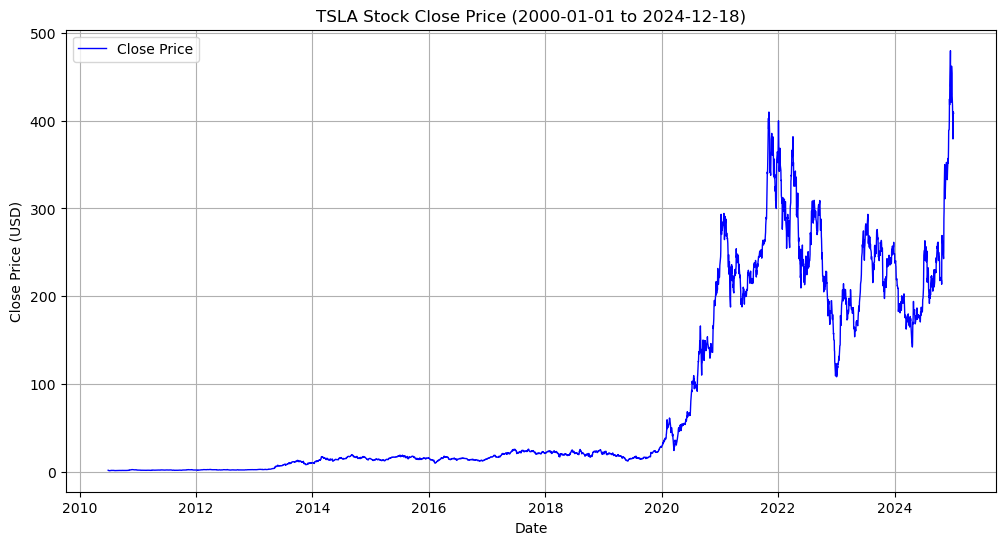

In [300]:
plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Close Price')

# Add labels and title
plt.title(f"{ticker} Stock Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)

In [301]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    # Calculate short-term (12) and long-term (26) EMAs
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    
    # Calculate MACD
    macd = short_ema - long_ema
    
    # Calculate signal line (9-day EMA of MACD)
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    
    return macd, signal_line

# Apply RSI and MACD to your 'Close' data
nvda['RSI'] = calculate_rsi(nvda['Close'])
nvda['MACD'], nvda['Signal_Line'] = calculate_macd(nvda['Close'])

def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Calculate the Exponential Moving Average (EMA)
def calculate_ema(data, window):
    return data['Close'].ewm(span=window, adjust=False).mean()

# Define the lookback windows for the moving averages
sma_window = 30  # 30-day Simple Moving Average
ema_window = 30  # 30-day Exponential Moving Average

# Add SMA and EMA to the dataframe
nvda['SMA'] = calculate_sma(nvda, sma_window)
nvda['EMA'] = calculate_ema(nvda, ema_window)

nvda = nvda.dropna()

## Data Preprocessing
#### LSTMs are sensitive to the scale of the data. Therefore, we need to apply the MinMax Scalar.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = ['Close', 'MACD', 'RSI', 'Volume']
num_features = len(features)

#nvda_close = nvda['Close'].values # Grabs the closing prices and stores it into a new dataframe
#nvda_volume = nvda['Volume'].values
scaler = MinMaxScaler(feature_range=(0,1)) # Initializes the scalar that scales values from 0 to 1 
nvda_scaled = nvda.copy()
nvda_scaled = scaler.fit_transform(nvda[features]) # Applies the scalar on 'nvda_close' to scale values to between 0 and 1.
#nvda_volume = scaler.fit_transform(np.array(nvda_volume).reshape(-1, 1))
nvda_scaled

array([[1.99157285e-04, 3.83648217e-01, 4.02026788e-01, 1.91186166e-02],
       [4.17809455e-05, 3.83488592e-01, 2.77408560e-01, 1.11656799e-02],
       [0.00000000e+00, 3.83345169e-01, 2.38101136e-01, 9.41297560e-03],
       ...,
       [7.89883453e-01, 6.63062737e-01, 3.87649845e-01, 1.18308306e-01],
       [8.54978236e-01, 6.32512176e-01, 4.70532113e-01, 1.01984480e-01],
       [8.51280641e-01, 6.03599051e-01, 4.28097198e-01, 4.98276727e-02]])

In [303]:
# Splits the data into the training and testing set in a 65-35 split.

train_val_set = nvda_scaled[:int(0.8 * len(nvda_scaled))] 
train_set = train_val_set[:int(0.8 * len(train_val_set))]
val_set = train_val_set[int(0.8 * len(train_val_set)):]
test_set = nvda_scaled[int(0.8 * len(nvda_scaled)):] 

In [304]:
def build_sequences(data, time_step):
    """Builds the time-step sequences to feed into the LSTM model."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        input = data[i : i + time_step]
        target = data[i + time_step]

        X.append(input), Y.append(target)
    return np.array(X), np.array(Y)

In [305]:
time_step = 100

X_train, Y_train = build_sequences(train_set, time_step)
X_val, Y_val = build_sequences(val_set, time_step)
X_test, Y_test = build_sequences(test_set, time_step)

#### Reshaping the data because an LSTM requires a 3D input shape: (number of samples, timesteps, number of features)

In [306]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], num_features)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], num_features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], num_features)

In [307]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [308]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (time_step, num_features)))
# model.add(Dropout(0.2))  # Add dropout
model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))  # Add dropout
model.add(LSTM(50))
# model.add(Dropout(0.2))  # Add dropout
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [309]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100, batch_size=10, verbose=1, callbacks= [early_stopping])
# model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100, batch_size=10, verbose=1)

Epoch 1/100


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.0541 - val_loss: 0.0551
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0504 - val_loss: 0.0586
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0491 - val_loss: 0.0531
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0485 - val_loss: 0.0487
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0490 - val_loss: 0.0518
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0485 - val_loss: 0.0513
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0493 - val_loss: 0.0502


In [310]:
test_predict = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


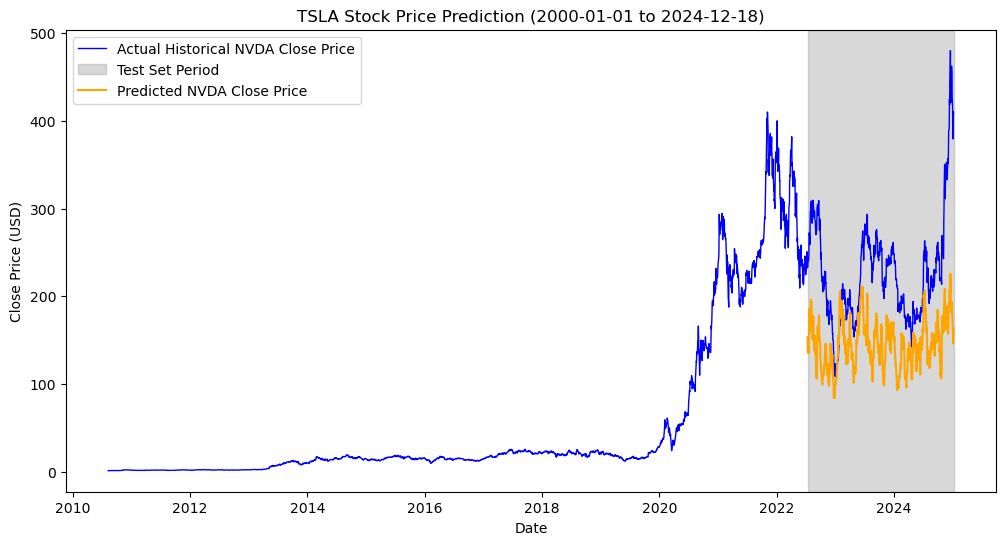

In [311]:
# Pad the test_predict and true test values to match the scaler's expected shape
test_predict_padded = np.zeros((test_predict.shape[0], scaler.n_features_in_))
test_predict_padded[:, 0] = test_predict[:, 0]  # Fill the "Close" predictions

y_test_padded = np.zeros((Y_test.shape[0], scaler.n_features_in_))
y_test_padded[:, 0] = Y_test[:, 0]  # Fill the true "Close" values

# Perform inverse transformation
test_predict_actual = scaler.inverse_transform(test_predict_padded)[:, 0]  # Extract the "Close" column
y_test_actual = scaler.inverse_transform(y_test_padded)[:, 0]  # Extract the "Close" column

test_dates = nvda.index[-len(y_test_actual):]

plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Actual Historical NVDA Close Price')
plt.axvspan(test_dates[0], test_dates[-1], color='gray', alpha=0.3, label='Test Set Period')
plt.plot(test_dates, test_predict_actual, color = 'orange', label='Predicted NVDA Close Price')
plt.title(f'{ticker} Stock Price Prediction ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

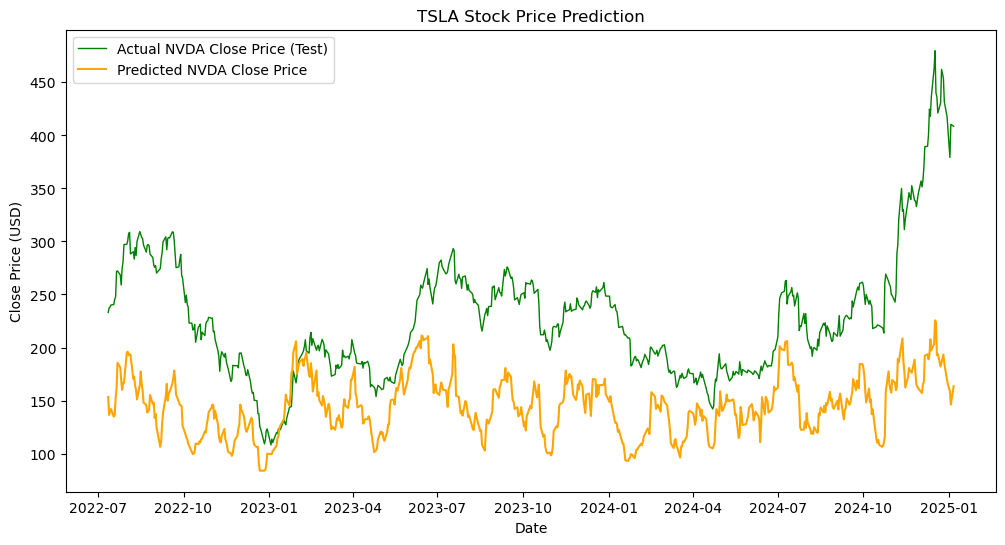

In [312]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual, color='green', linewidth=1, label='Actual NVDA Close Price (Test)')
plt.plot(test_dates, test_predict_actual, color = 'orange', label='Predicted NVDA Close Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel("Close Price (USD)")
plt.legend()
plt.show()

In [313]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

print("Root Mean Squared Error: "+ str(root_mean_squared_error(y_test_actual, test_predict_actual)))
print("Mean Absolute Error: "+ str(mean_absolute_error(y_test_actual, test_predict_actual)))
print("R-Squared: "+ str(r2_score(y_test_actual, test_predict_actual)))
print("Mean Absolute Percentage Error: " + str(mean_absolute_percentage_error(y_test_actual, test_predict_actual)))

Root Mean Squared Error: 95.15945781069371
Mean Absolute Error: 82.30272590124012
R-Squared: -1.585755422951542
Mean Absolute Percentage Error: 0.3415698688181208
